# Binary Classification Model for Customer Transaction Prediction Using Python (Balanced Random Forest)
### David Lowe
### March 25, 2019

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a prediction model using various machine learning algorithms and to document the end-to-end steps using a template. The Santander Bank Customer Transaction Prediction competition is a binary classification situation where we are trying to predict one of the two possible outcomes.

INTRODUCTION: Santander Bank's data science team wants to identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted. The bank is continually challenging its machine learning algorithms to make sure they can more accurately identify new ways to solve its most common challenges such as: Will a customer buy this product? Can a customer pay this loan?

For this iteration, we will examine the effectiveness of the Balanced Random Forest classifier (from the imbalanced-learn package) with inner balancing samplers to mitigate the effect of imbalanced data for this problem. Submissions are evaluated on the area under the ROC curve between the predicted probability and the observed target.

ANALYSIS: The baseline performance achieved an average ROC-AUC score of 0.8224. After a series of tuning trials, the top result from the training data was a ROC-AUC score of 0.8660. By using the optimized parameters, the algorithm processed the test dataset with a ROC-AUC score of 0.7761.

CONCLUSION: To be determined after comparing the results from other machine learning algorithms.

Dataset Used: Santander Customer Transaction Prediction

Dataset ML Model: Binary classification with numerical attributes

Dataset Reference: https://www.kaggle.com/c/santander-customer-transaction-prediction/data

One potential source of performance benchmark: https://www.kaggle.com/c/santander-customer-transaction-prediction/overview

The project aims to touch on the following areas:

* Document a predictive modeling problem end-to-end.
* Explore data cleaning and transformation options
* Explore non-ensemble and ensemble algorithms for baseline model performance
* Explore algorithm tuning techniques for improving model performance

Any predictive modeling machine learning project genrally can be broken down into about six major tasks:

1. Prepare Problem
2. Summarize Data
3. Prepare Data
4. Model and Evaluate Algorithms
5. Improve Accuracy or Results
6. Finalize Model and Present Results

## Section 1 - Prepare Problem
### 1.a) Load ibraries

In [1]:
import math
import numpy as np
import pandas as pd
import os
import shutil
import urllib.request
import zipfile
import warnings
import smtplib
from datetime import datetime
from email.message import EmailMessage
from matplotlib import pyplot
from pandas import read_csv
from pandas import get_dummies
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.externals.joblib import dump
from sklearn.externals.joblib import load
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier

# Create one random seed number for reproducible results
seedNum = 888

### 1.b) Set up the email notification function

In [2]:
def email_notify(msg_text):
    sender = "luozhi2488@gmail.com"
    receiver = "dave@contactdavidlowe.com"
    with open('../../email_credential.txt') as f:
        password = f.readline()
        f.close()
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Python Binary Classification Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP('smtp.gmail.com', 587)
    server.starttls()
    server.login(sender, password)
    server.send_message(msg)
    server.quit()

In [3]:
email_notify("Library and Data Loading has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [4]:
startTimeScript = datetime.now()

dataset_path = 'https://www.kaggle.com/c/santander-customer-transaction-prediction/download/train.csv'
dest_file = os.path.basename(dataset_path)
# if (os.path.isfile(dest_file) == False) :
#     print('Downloading ' + dataset_path + ' as ' + dest_file)
#     with urllib.request.urlopen(dataset_path) as in_resp, open(dest_file, 'wb') as out_file:
#         shutil.copyfileobj(in_resp, out_file)
#     print(dest_file + 'downloaded!')
#     print('Unpacking ' + dest_file)
#     with zipfile.ZipFile(dest_file, 'r') as zip_ref:
#         zip_ref.extractall('.')
#     print(dest_file + 'unpacked!')

inputFile = dest_file
xy_original_df = read_csv(inputFile, sep=',', index_col=False)
xy_original_df.drop('ID_code',axis=1,inplace=True)

In [5]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(xy_original_df.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

In [6]:
# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = 1

# Standardize the class column to the name of targetVar if required
xy_original_df = xy_original_df.rename(columns={'target': 'targetVar'})

In [7]:
# We create training datasets (xy_train_df, x_train_df, y_train_df) for various visualization and cleaning/transformation operations
# We create testing datasets (x_test_df, y_test_df) for various visualization and cleaning/transformation operations
# Use 70% of the data to train the models and the remaining for testing/validation

if targetCol == totCol:
    x_original_df = xy_original_df.iloc[:,0:totAttr]
    y_original_df = xy_original_df.iloc[:,totAttr]
else:
    x_original_df = xy_original_df.iloc[:,1:totCol]
    y_original_df = xy_original_df.iloc[:,0]

validation_size = 0.30
x_train_df, x_test_df, y_train_df, y_test_df = train_test_split(x_original_df, y_original_df, test_size=validation_size, random_state=seedNum)
xy_train_df = pd.concat([x_train_df, y_train_df], axis=1)
print("xy_original_df.shape: {} xy_train_df.shape: {}".format(xy_original_df.shape, xy_train_df.shape))
print("x_train_df.shape: {} y_train_df.shape: {}".format(x_train_df.shape, y_train_df.shape))
print("x_test_df.shape: {} y_test_df.shape: {}".format(x_test_df.shape, y_test_df.shape))

xy_original_df.shape: (200000, 201) xy_train_df.shape: (140000, 201)
x_train_df.shape: (140000, 200) y_train_df.shape: (140000,)
x_test_df.shape: (60000, 200) y_test_df.shape: (60000,)


### 1.d) Set up the key parameters to be used in the script

In [8]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 3
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to 16 and height to 12 (4:3 aspect ratio)
fig_size = pyplot.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 12
pyplot.rcParams["figure.figsize"] = fig_size

# Set the warning message filter
warnings.filterwarnings("ignore", category=FutureWarning)

In [9]:
email_notify("Library and Data Loading completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 2 - Summarize Data
To gain a better understanding of the data that we have on-hand, we will leverage a number of descriptive statistics and data visualization techniques. The plan is to use the results to consider new questions, review assumptions, and validate hypotheses that we can investigate later with specialized models.

In [10]:
email_notify("Data Summarization and Visualization has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 2.a) Descriptive statistics

#### 2.a.i) Peek at the data itself.

In [11]:
xy_train_df.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,targetVar
62824,9.3297,-2.2958,13.8450,6.7170,11.1910,-6.3281,3.6014,15.3160,-2.1185,6.1505,...,9.1690,1.5574,6.6926,22.2004,0.4653,-0.9314,7.3704,13.9909,-11.1948,0
35463,8.8205,-5.1823,13.4572,6.3583,9.8454,-7.0326,5.3683,19.2255,-0.8516,6.1638,...,9.3949,6.1643,4.2330,18.8487,-0.3255,6.2714,7.6188,10.2298,5.9419,0
51579,7.2094,5.6705,8.9917,2.4625,10.6040,-7.6758,5.6306,21.5245,0.7456,5.3397,...,10.1736,1.3238,-0.8232,14.9173,1.0350,9.7769,7.1368,19.6281,0.8843,0
165164,10.2260,-8.8893,11.3938,8.1316,8.4619,-8.6174,6.3148,20.8304,-1.8230,7.1246,...,5.5738,1.9381,-5.1487,16.9208,-1.2639,3.4729,8.1272,15.0752,-6.8129,0
125207,6.5347,0.3578,7.9561,3.0195,11.4697,-12.9661,3.8820,16.2908,2.4811,6.5964,...,14.9574,3.1190,0.6334,17.9840,-0.6914,7.3110,9.4617,16.9748,6.4416,0


#### 2.a.ii) Dimensions of the dataset.

In [12]:
xy_train_df.shape

(140000, 201)

#### 2.a.iii) Types of the attributes.

In [13]:
xy_train_df.info()
xy_train_df.dtypes

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140000 entries, 62824 to 10750
Columns: 201 entries, var_0 to targetVar
dtypes: float64(200), int64(1)
memory usage: 215.8 MB


var_0        float64
var_1        float64
var_2        float64
var_3        float64
var_4        float64
var_5        float64
var_6        float64
var_7        float64
var_8        float64
var_9        float64
var_10       float64
var_11       float64
var_12       float64
var_13       float64
var_14       float64
var_15       float64
var_16       float64
var_17       float64
var_18       float64
var_19       float64
var_20       float64
var_21       float64
var_22       float64
var_23       float64
var_24       float64
var_25       float64
var_26       float64
var_27       float64
var_28       float64
var_29       float64
              ...   
var_171      float64
var_172      float64
var_173      float64
var_174      float64
var_175      float64
var_176      float64
var_177      float64
var_178      float64
var_179      float64
var_180      float64
var_181      float64
var_182      float64
var_183      float64
var_184      float64
var_185      float64
var_186      float64
var_187      

#### 2.a.iv) Statistical summary of all attributes.

In [14]:
xy_train_df.describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,targetVar
count,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,...,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000
mean,10.681657,-1.622382,10.719087,6.793610,11.082699,-5.084031,5.408501,16.551609,0.282552,7.565824,...,7.440210,1.925769,3.331502,17.998757,-0.140089,2.290811,8.907276,15.874419,-3.324348,0.101421
std,3.040667,4.047725,2.641914,2.043649,1.620770,7.863467,0.865468,3.418347,3.333568,1.235655,...,3.023324,1.478147,3.992782,3.133282,1.428656,5.446338,0.921585,3.009209,10.433128,0.301887
min,0.408400,-14.696200,2.169300,0.043000,5.074800,-32.562600,2.347300,5.749400,-10.505500,4.177100,...,-1.918900,-3.814500,-10.845500,8.694400,-5.048100,-14.209600,6.047600,6.558700,-38.852800,0.000000
25%,8.460300,-4.728925,8.727600,5.251800,9.890600,-11.217600,4.767975,13.949400,-2.315100,6.617900,...,5.158175,0.889200,0.586600,15.640275,-1.167000,-1.958100,8.252000,13.834700,-11.199500,0.000000
50%,10.524350,-1.604250,10.587000,6.825700,11.111450,-4.844500,5.385600,16.462500,0.389350,7.627400,...,7.352400,1.897750,3.393900,17.962900,-0.171200,2.396350,8.888400,15.937850,-2.817750,0.000000
75%,12.760800,1.362225,12.518000,8.319800,12.265700,0.924200,6.001725,19.106325,2.935500,8.584500,...,9.514600,2.941800,6.209925,20.395100,0.828200,6.543825,9.591625,18.064450,4.828825,0.000000
max,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.285200,27.691800,10.151300,11.150600,...,16.716500,7.611600,17.908600,27.928800,4.272900,18.321500,12.000400,26.079100,27.531900,1.000000


#### 2.a.v) Count missing values.

In [15]:
print('Number of NaN in the dataframe columns:\n', xy_train_df.isnull().sum())
print('Total number of NaN in the dataframe: ', xy_train_df.isnull().sum().sum())

Number of NaN in the dataframe columns:
 var_0        0
var_1        0
var_2        0
var_3        0
var_4        0
var_5        0
var_6        0
var_7        0
var_8        0
var_9        0
var_10       0
var_11       0
var_12       0
var_13       0
var_14       0
var_15       0
var_16       0
var_17       0
var_18       0
var_19       0
var_20       0
var_21       0
var_22       0
var_23       0
var_24       0
var_25       0
var_26       0
var_27       0
var_28       0
var_29       0
            ..
var_171      0
var_172      0
var_173      0
var_174      0
var_175      0
var_176      0
var_177      0
var_178      0
var_179      0
var_180      0
var_181      0
var_182      0
var_183      0
var_184      0
var_185      0
var_186      0
var_187      0
var_188      0
var_189      0
var_190      0
var_191      0
var_192      0
var_193      0
var_194      0
var_195      0
var_196      0
var_197      0
var_198      0
var_199      0
targetVar    0
Length: 201, dtype: int64
Total number of Na

#### 2.a.vi) Summarize the levels of the class attribute.

In [16]:
xy_train_df.groupby('targetVar').size()

targetVar
0    125801
1     14199
dtype: int64

### 2.b) Data visualizations

##### 2.b.i) Univariate plots to better understand each attribute

In [17]:
# Histograms for each attribute
# x_train_df.hist()
# pyplot.show()

In [18]:
# Density plot for each attribute
# x_train_df.plot(kind='density', subplots=True, layout=(dispRow,dispCol), sharex=False, sharey=False)
# pyplot.show()

In [19]:
# Box and Whisker plot for each attribute
# x_train_df.plot(kind='box', subplots=True, layout=(dispRow,dispCol), sharex=False, sharey=False)
# pyplot.show()

#### 2.b.ii) Multivariate plots to better understand the relationships between attributes

In [20]:
# Scatterplot matrix
# scatter_matrix(x_train_df)
# pyplot.show()

In [21]:
# Correlation matrix
# fig = pyplot.figure()
# ax = fig.add_subplot(111)
# correlations = x_train_df.corr(method='pearson')
# cax = ax.matshow(correlations, vmin=-1, vmax=1)
# fig.colorbar(cax)
# pyplot.show()

In [22]:
email_notify("Data Summarization and Visualization completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 3 - Prepare Data
Some dataset may require additional preparation activities that will best exposes the structure of the problem and the relationships between the input attributes and the output variable. Some data-prep tasks might include:

* Cleaning data by removing duplicates, marking missing values and even imputing missing values.
* Feature selection where redundant features may be removed.
* Data transforms where attributes are scaled or redistributed in order to best expose the structure of the problem later to learning algorithms.

In [23]:
email_notify("Data Cleaning and Transformation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Data Cleaning

In [24]:
# Not applicable for this iteration of the project
# Sample code for performing one-hot-encoding (Block #1 of 2)
# According to the data dictionary, columns SOME_ATTR should be converted to categorical type
# x_train_df['SOME_ATTR'] = x_train_df['SOME_ATTR'].astype('category')

# # Apply the One-Hot-Encoding (dummy variable handling) technique
# x_train_df = get_dummies(x_train_df)
# print(x_train_df.dtypes)

In [25]:
# Sample code for performing one-hot-encoding (Block #2 of 2)
# According to the data dictionary, columns SOME_ATTR should be converted to categorical type
# x_train_df['SOME_ATTR'] = x_train_df['SOME_ATTR'].astype('category')

# # Apply the One-Hot-Encoding (dummy variable handling) technique
# x_test_df = get_dummies(x_test_df)
# print(x_test_df.dtypes)

### 3.b) Data Transforms

In [26]:
# Sample code for performing SMOTE transformation on the training data (Block #1 of 2)
# x_train_imbal = x_train_df.values
# y_train_imbal = y_train_df.values.ravel()
# print("x_train_imbal.shape: {} y_train_imbal.shape: {}".format(x_train_imbal.shape, y_train_imbal.shape))

In [27]:
# Sample code for performing SMOTE transformation on the training data (Block #2 of 2)
# print ('Original class distribution - 1: {} | 0: {}'.format((y_train_imbal==1).sum(), (y_train_imbal==0).sum()))
# sm = SMOTE(random_state=seedNum)
# x_train, y_train = sm.fit_sample(x_train_imbal, y_train_imbal)
# print ('Resampled class distribution - 1: {} | 0: {}'.format((y_train==1).sum(), (y_train==0).sum()))

### 3.c) Feature Selection

In [28]:
# Sample code for performing Attribute Importance Ranking (Block #1 of 3)
# Feature Importance with Gradient Boosting Classifier
# x_impVal = x_train_df.values
# y_impVal = y_train_df.values.ravel()
# model = GradientBoostingClassifier(random_state=seedNum)
# model.fit(x_impVal, y_impVal)
# importanceScore = model.feature_importances_
# attributeList = x_train_df.columns.tolist()
# attributeImportance = pd.DataFrame({'attribute': attributeList, 'importance': importanceScore})
# rankedAttributes = attributeImportance.sort_values('importance', ascending=False)
# print(rankedAttributes)

In [29]:
# Sample code for performing Attribute Importance Ranking (Block #2 of 3)
# Set the importance threshold and calculate the list of attributes that don't contribute to the importance threshold
# importanceSum = sum(importanceScore)
# maxThreshold = 0.99
# i = 0
# accumWeight = 0
# exit_now = False
# while ((i < totAttr) and (not exit_now)) :
#     accumWeight = accumWeight + (rankedAttributes.iloc[i]['importance']/importanceSum)
#     if (accumWeight >= maxThreshold) :
#         exit_now = True
#     else :
#         i = i + 1
# print('Number of attributes contributed to the importance threshold:'+str(i))
# lowAttributes = rankedAttributes.iloc[(i):(totAttr),]['attribute'].tolist()
# print('Number of attributes found to be of low importance:',len(lowAttributes))
# print(lowAttributes)

In [30]:
# Sample code for performing Attribute Importance Ranking (Block #3 of 3)
# Removing the unselected attributes from the training and validation dataframes
# x_train_df.drop(labels=lowAttributes, axis=1, inplace=True)
# x_test_df.drop(labels=lowAttributes, axis=1, inplace=True)

In [31]:
# Not applicable for this iteration of the project
# Using the Logistic Regression algorithm, we perform the Recursive Feature Elimination (RFE) technique
# x_rfeVal = x_train_df.values
# y_rfeVal = y_train_df.values.ravel()
# estimator = LogisticRegression(random_state=seedNum)
# selector = RFE(estimator, 40)
# selector = selector.fit(x_rfeVal, y_rfeVal)
# print('The number of selected features:',selector.n_features_)
# print('The mask of selected features:\n',selector.support_)
# print('The mask of selected features:\n',selector.ranking_)

In [32]:
# Remove the unselected attributes from the training dataframes
# x_train_df = x_train_df[x_train_df.columns[selector.support_]]
# print(x_train_df.shape)
# x_train_df.head()

In [33]:
# Remove the unselected attributes from the validation dataframes
# x_test_df = x_test_df[x_test_df.columns[selector.support_]]
# print(x_test_df.shape)
# x_test_df.head()

### 3.d) Display the Final Datasets for Model-Building

In [34]:
# We finalize the training and testing datasets for the modeling activities
x_train = x_train_df.values
y_train = y_train_df.values.ravel()
x_test = x_test_df.values
y_test = y_test_df.values.ravel()
print("x_train.shape: {} y_train.shape: {}".format(x_train.shape, y_train.shape))
print("x_test.shape: {} y_test.shape: {}".format(x_test.shape, y_test.shape))
email_notify("Data Cleaning and Transformation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

x_train.shape: (140000, 200) y_train.shape: (140000,)
x_test.shape: (60000, 200) y_test.shape: (60000,)


## 4. Model and Evaluate Algorithms
After the data-prep, we next work on finding a workable model by evaluating a subset of machine learning algorithms that are good at exploiting the structure of the training. The typical evaluation tasks include:

* Defining test options such as cross validation and the evaluation metric to use.
* Spot checking a suite of linear and nonlinear machine learning algorithms.
* Comparing the estimated accuracy of algorithms.

For this project, we will evaluate one linear, two non-linear and four ensemble algorithms:

Linear Algorithm: Logistic Regression

Non-Linear Algorithms: Decision Trees (CART) and k-Nearest Neighbors

Ensemble Algorithms: Bagged CART, Random Forest, Extra Trees, and Stochastic Gradient Boosting

The random number seed is reset before each run to ensure that the evaluation of each algorithm is performed using the same data splits. It ensures the results are directly comparable.

### 4.a) Set test options and evaluation metric

In [35]:
# Run algorithms using 10-fold cross validation
num_folds = 10
scoring = 'roc_auc'

In [36]:
# Set up Algorithms Spot-Checking Array
models = []
# models.append(('LR', LogisticRegression(random_state=seedNum, solver='liblinear')))
# models.append(('CART', DecisionTreeClassifier(random_state=seedNum)))
# models.append(('KNN', KNeighborsClassifier()))
# models.append(('BT', BaggingClassifier(random_state=seedNum)))
# models.append(('RF', RandomForestClassifier(random_state=seedNum, n_estimators=100)))
# models.append(('ET', ExtraTreesClassifier(random_state=seedNum)))
models.append(('BRF-NONE', BalancedRandomForestClassifier(random_state=seedNum, max_features=None)))
models.append(('BRF-SQRT', BalancedRandomForestClassifier(random_state=seedNum, max_features="sqrt")))
models.append(('BRF-LOG2', BalancedRandomForestClassifier(random_state=seedNum, max_features="log2")))
results = []
names = []
metrics = []

In [37]:
# Generate model in turn
for name, model in models:
	email_notify("Algorithm "+name+" modeling has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	startTimeModule = datetime.now()
	kfold = KFold(n_splits=num_folds, random_state=seedNum)
	cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	metrics.append(cv_results.mean())
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
	print ('Model training time:',(datetime.now() - startTimeModule))
	email_notify("Algorithm "+name+" modeling completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics ('+scoring+') from all models:',np.mean(metrics))

BRF-NONE: 0.803668 (0.005496)
Model training time: 1:54:13.786732
BRF-SQRT: 0.828620 (0.005783)
Model training time: 0:08:38.788417
BRF-LOG2: 0.834927 (0.004372)
Model training time: 0:04:57.030099
Average metrics (roc_auc) from all models: 0.8224052223739093


### 4.b) Spot-checking baseline algorithms

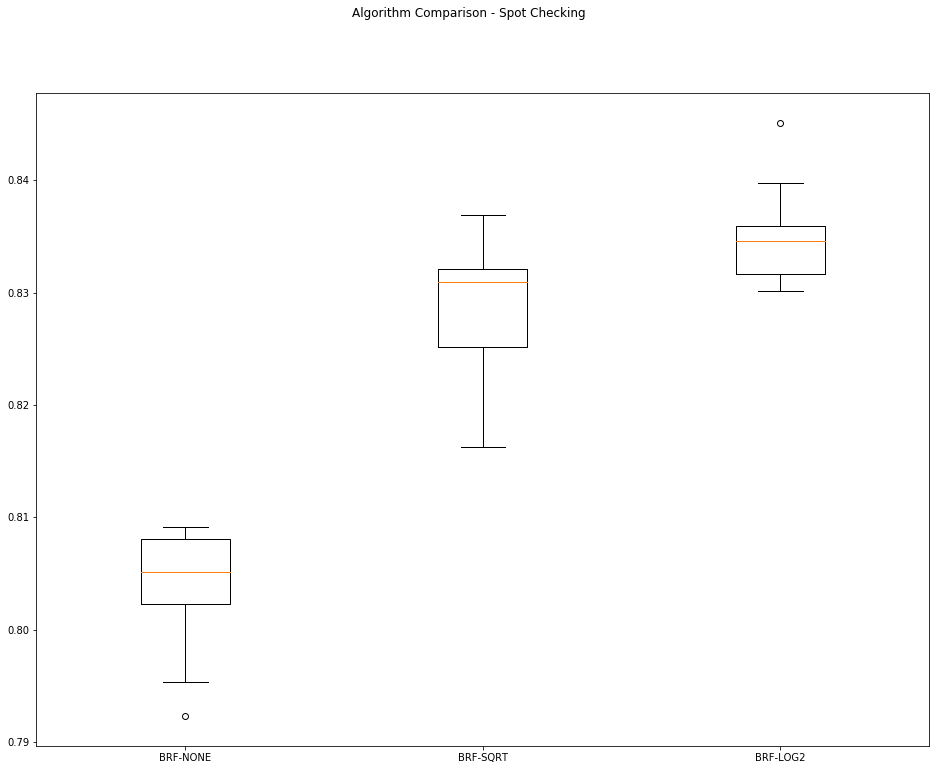

In [38]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

## Section 5 - Improve Accuracy
After we achieve a short list of machine learning algorithms with good level of accuracy, we can leverage ways to improve the accuracy of the models.

### 5.a) Algorithm Tuning

In [39]:
# Set up the comparison array
results = []
names = []

In [40]:
# Tuning algorithm #1 - Stochastic Gradient Boosting
email_notify("Algorithm tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
startTimeModule = datetime.now()
paramGrid1 = dict(n_estimators=np.array([200,300,400]))
model1 = BalancedRandomForestClassifier(random_state=seedNum, max_features="log2")
kfold = KFold(n_splits=num_folds, random_state=seedNum)
grid1 = GridSearchCV(estimator=model1, param_grid=paramGrid1, scoring=scoring, cv=kfold)
grid_result1 = grid1.fit(x_train, y_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
results.append(grid_result1.cv_results_['mean_test_score'])
names.append('BRF')
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
email_notify("Algorithm tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Best: 0.866065 using {'n_estimators': 400}
0.854792 (0.004377) with: {'n_estimators': 200}
0.862133 (0.004050) with: {'n_estimators': 300}
0.866065 (0.003365) with: {'n_estimators': 400}
Model training time: 0:52:09.369680


### 5.b) Compare Algorithms After Tuning

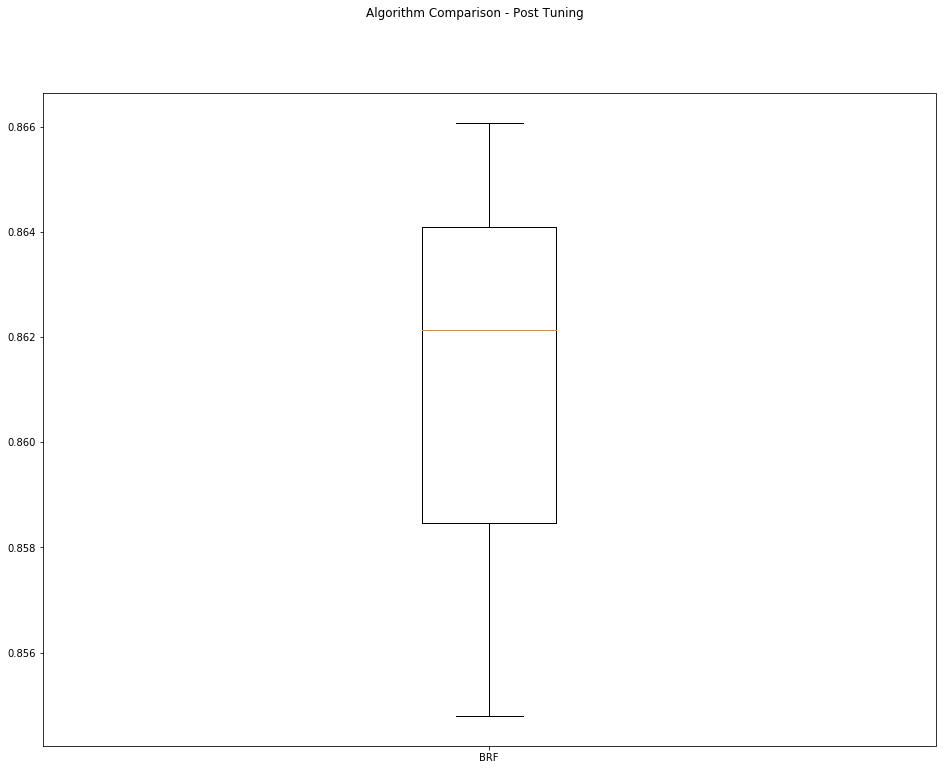

In [41]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

## Section 6 - Finalize Model
Once we have narrow down to a model that we believe can make accurate predictions on unseen data, we are ready to finalize it. Finalizing a model may involve sub-tasks such as:
* Using an optimal model tuned to make predictions on unseen data.
* Creating a standalone model using the tuned parameters
* Saving an optimal model to file for later use.

In [42]:
email_notify("Model Validation and Final Model Creation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 6.a) Predictions on validation dataset

In [43]:
finalModel = BalancedRandomForestClassifier(random_state=seedNum, max_features="log2", n_estimators=300)
finalModel.fit(x_train, y_train)
predictions = finalModel.predict(x_test)

In [44]:
print('ROC/AUC Score:',roc_auc_score(y_test, predictions))
print('Accuracy Score:',accuracy_score(y_test, predictions))
print('Confusion Matrix:\n',confusion_matrix(y_test, predictions))
print('Classification Report:\n',classification_report(y_test, predictions))

ROC/AUC Score: 0.7761298497286468
Accuracy Score: 0.7618833333333334
Confusion Matrix:
 [[41030 13071]
 [ 1216  4683]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.76      0.85     54101
           1       0.26      0.79      0.40      5899

   micro avg       0.76      0.76      0.76     60000
   macro avg       0.62      0.78      0.62     60000
weighted avg       0.90      0.76      0.81     60000



### 6.b) Prepare the Final Output File

In [45]:
startTimeModule = datetime.now()

# Combining the training and testing datasets to form the complete dataset that will be used for training the final model
x_complete = np.vstack((x_train, x_test))
y_complete = np.concatenate((y_train, y_test))
print("x_complete.shape: {} y_complete.shape: {}".format(x_complete.shape, y_complete.shape))

finalModel.fit(x_complete, y_complete)
print ('Model training time:',(datetime.now() - startTimeModule))

x_complete.shape: (200000, 200) y_complete.shape: (200000,)
Model training time: 0:03:25.581234


In [46]:
inputFile = 'test.csv'
x_validation_df = read_csv(inputFile, sep=',', index_col=False)

y_submission_df = pd.DataFrame(columns=['ID_code','target'])
y_submission_df['ID_code'] = x_validation_df['ID_code']
x_validation_df.drop('ID_code',axis=1,inplace=True)
# x_validation_df.drop(labels=lowAttributes, axis=1, inplace=True)

In [47]:
print("x_validation_df.shape: {} y_submission_df.shape: {}".format(x_validation_df.shape, y_submission_df.shape))

x_validation_df.shape: (200000, 200) y_submission_df.shape: (200000, 2)


In [48]:
print(x_validation_df.head())

     var_0    var_1    var_2   var_3    var_4   var_5   var_6    var_7  \
0  11.0656   7.7798  12.9536  9.4292  11.4327 -2.3805  5.8493  18.2675   
1   8.5304   1.2543  11.3047  5.1858   9.1974 -4.0117  6.0196  18.6316   
2   5.4827 -10.3581  10.1407  7.0479  10.2628  9.8052  4.8950  20.2537   
3   8.5374  -1.3222  12.0220  6.5749   8.8458  3.1744  4.9397  20.5660   
4  11.7058  -0.1327  14.1295  7.7506   9.1035 -8.5848  6.8595  10.6048   

    var_8   var_9   ...     var_190  var_191  var_192  var_193  var_194  \
0  2.1337  8.8100   ...     -2.1556  11.8495  -1.4300   2.4508  13.7112   
1 -4.4131  5.9739   ...     10.6165   8.8349   0.9403  10.1282  15.5765   
2  1.5233  8.3442   ...     -0.7484  10.9935   1.9803   2.1800  12.9813   
3  3.3755  7.4578   ...      9.5702   9.0766   1.6580   3.5813  15.1874   
4  2.9890  7.1437   ...      4.2259   9.1723   1.2835   3.3778  19.5542   

   var_195  var_196  var_197  var_198  var_199  
0   2.4669   4.3654  10.7200  15.4722  -8.7197  
1   0.

In [49]:
submissions = finalModel.predict(x_validation_df)
y_submission_df['target'] = submissions
print(y_submission_df.head())

  ID_code  target
0  test_0       1
1  test_1       1
2  test_2       1
3  test_3       0
4  test_4       0


In [50]:
y_submission_df.groupby('target').size()

target
0    140528
1     59472
dtype: int64

In [51]:
# out_file = y_submission_df.to_csv(header=True,index=False)
# filename = 'submission_' + datetime.now().strftime('%Y%m%d-%H%M') + '.csv'
# with open(filename, 'w') as f:
#     f.write(out_file)

In [52]:
email_notify("Model Validation and Final Model Creation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 3:07:42.033729
